## Build Score Model

### Objective

* Creates the comprehensive set of scoring models for all players and courses in the database, using an ElasticNetCV linear regression for weather parameters when a player has sufficient games on the same course, an ARIMA(0,1,0) model when a player has 4 or more game on the same course but not enough for a weather-based model, a same-course average if the player has one or more games on the same course, and an off-course average when a player has no games on the same course.  Also computes an estimated error from (in order of preference), same-course mse, all-course mse, or, when there is only one game available, an imputed first-vs-second game sme on either the same course or all-course, as the situation requires.  

### Rationale

*  Why This?  The models are a key component of the service offered by the system, and need a production-ready ETL method

*  Why Me?  As the main model architect, I am the logical choice

*  Why Now?  Successful trial runs with earlier models have accomplished preliminary optimization and established usefulness with user feedback.  Having a production-level model-building system now will enable us to receive maximum benefit from early deployments.

### Requirements

*  Pandas 0.24.2
*  Scikit-learn 0.21.2
*  Numpy 1.16.4
*  Matplotlib 3.1.0

### Input / Output

*  This notebook is expected to be in `models/notebooks`

*  The input weather data is in a file `models/wx_model_data/wx_model.csv`

*  The input score data is in a file `models/score_model_data/scores.csv`

*  The output models are stored in a file `models/score_model_data/score_model.csv` with a second copy as `models/scoer_model_data/score_model_{YYYYMMDD}{[a-z]}` where YYYYMMDD is the year, month, and day the model was generated, and a lower-case letter auto-increments for tracking.  `score_model.csv` is moved to `scoreCalculator/data` for deployed use.

### Import / Set-Up

In [2]:
import pandas as pd
import sklearn as sk
import numpy as np
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Get weather data
wx_df = pd.read_csv('../wx_model_data/wx_model.csv', parse_dates = ['date'])
# Get scores data
scores_df = pd.read_csv('../score_model_data/scores.csv', parse_dates = ['time'])

In [4]:
wx_df.head()

Unnamed: 0       date  weighted_T  weighted_w_dir  weighted_w_spd  \
0           0 2018-11-11   62.987163       59.560057        5.091894   
1           1 2018-12-09   49.491667       68.116667        3.919444   
2           2 2018-12-17   52.000000      135.000000        0.000000   
3           3 2019-01-06   51.505556      153.133333        4.384722   
4           4 2019-08-03   56.631841      226.426190        3.021159   

   weighted_w_gust  weighted_rh  weighted_precip  weighted_w_u  weighted_w_v  \
0        15.866667    26.821613         0.000000      2.632290      3.792724   
1        13.133333    90.988889         0.000000      2.100778      2.822686   
2         9.000000    93.000000         0.010000      0.000000      0.000000   
3        20.933333    89.798611         0.105625      0.829178     -3.227827   
4        12.866667    96.149492         0.000203     -2.264058     -1.859965   

   w_gust_var   w_dir_var    w_uv_var  course_id  
0    2.382222  115.436274  111.370212          0  
1    2.915556  490.203981   41.108702          0  
2    0.000000    0.000000    0.000000          0  
3    6.995556  214.376551  906.500313          0  
4    1.448889   15.888444   17.074903          0

In [5]:
scores_df.head()

id                 Name  Raw  Handicap  Adjusted                time  \
0   0         Mark Shannon   61    -12.40     48.60 2019-01-19 08:00:00   
1   1  Jacob Kermish-Wells   60    -10.72     49.28 2019-01-19 08:00:00   
2   2         Luiz Celeste   55     -5.23     49.77 2019-01-19 08:00:00   
3   3              Tu Tran   59     -9.07     49.93 2019-01-19 08:00:00   
4   4         Matty Angell   53     -1.50     51.50 2019-01-19 08:00:00   

   course_id  
0          1  
1          1  
2          1  
3          1  
4          1

In [6]:
# Clean out duplicated indexes
wx_df = wx_df.drop(columns = 'Unnamed: 0')
scores_df = scores_df.drop(columns = 'id')

In [7]:
# Sort prior to merge
wx_df = wx_df.sort_values(by = ['date','course_id'])
scores_df = scores_df.sort_values(by= ['time','course_id','Name'])

In [8]:
# Merge
all_df = pd.merge_asof(scores_df, wx_df, by = 'course_id', left_on= 'time', right_on = 'date',
                       direction = 'backward', tolerance = pd.Timedelta('1d') )
all_df.head()

Name  Raw  Handicap  Adjusted                time  course_id  \
0       Alex Torres   68       NaN       NaN 2012-11-18 07:30:00          0   
1         Andy Leaf   53       NaN       NaN 2012-11-18 07:30:00          0   
2  Anthony McGinnis   78       NaN       NaN 2012-11-18 07:30:00          0   
3  Aurelius Lewicki   57       NaN       NaN 2012-11-18 07:30:00          0   
4      Billy Manger   58       NaN       NaN 2012-11-18 07:30:00          0   

  date  weighted_T  weighted_w_dir  weighted_w_spd  weighted_w_gust  \
0  NaT         NaN             NaN             NaN              NaN   
1  NaT         NaN             NaN             NaN              NaN   
2  NaT         NaN             NaN             NaN              NaN   
3  NaT         NaN             NaN             NaN              NaN   
4  NaT         NaN             NaN             NaN              NaN   

   weighted_rh  weighted_precip  weighted_w_u  weighted_w_v  w_gust_var  \
0          NaN              NaN           NaN           NaN         NaN   
1          NaN              NaN           NaN           NaN         NaN   
2          NaN              NaN           NaN           NaN         NaN   
3          NaN              NaN           NaN           NaN         NaN   
4          NaN              NaN           NaN           NaN         NaN   

   w_dir_var  w_uv_var  
0        NaN       NaN  
1        NaN       NaN  
2        NaN       NaN  
3        NaN       NaN  
4        NaN       NaN

### Prepare imputation estimates 

* Use as needed for when players have only ever played once or got an unrealistically low variation in scores:
    * Single game on current course only -- use 1st game mean and historical 1st/2nd game average mse for all players on course
    * Single game on a different course -- use existing game mean and historical 1st/2nd game (different course) average mse for all players
    * Low standard deviation cut-off -- use the 5th percentile of all observed standard deviations

In [9]:
# Generate different course 1st to 2nd game estimate
player_names = all_df['Name'].unique()
diffs = []
for player in player_names:
    player_df = all_df[all_df['Name'] == player].sort_values(by = 'time')
    if len(player_df) > 1:
        scores = player_df[['course_id','Raw']].groupby('course_id')['Raw'].first().values
        if len(scores) > 1:
            diffs.append(scores[1] - scores[0])
if len(diffs) > 1:
    mse1to2_different_course = np.std(diffs) * np.std(diffs)
else:
    mse1to2_different_course = 6 * 6
mse1to2_different_course

37.30478395061729

In [10]:
# Generate same course 1st to 2nd game estimate
mse1to2_same_course = []
for course_num in range(all_df['course_id'].max() + 1):
    same_course_df = all_df[all_df['course_id'] == course_num]
    player_names = same_course_df['Name'].unique()
    diffs = []
    for player in player_names:
        player_df = same_course_df[same_course_df['Name'] == player].sort_values(by = 'time')
        if len(player_df) > 1:
            scores = player_df['Raw'].tolist()
            if len(scores) > 1:
                diffs.append(scores[1] - scores[0])
    if len(diffs) > 1:
        mse1to2_same_course.append(np.std(diffs) * np.std(diffs))
    else:
        mse1to2_same_course.append(6 * 6)
mse1to2_same_course

[28.547822339223522, 32.90227440828402, 33.77324263038549]

In [11]:
# Generate low standard deviation cut-off at 5th percentile 
player_stdev = all_df[['Name','Raw']].groupby('Name').std()
low_std_cutoff = player_stdev['Raw'].quantile(q=0.05)
low_var_cutoff = low_std_cutoff * low_std_cutoff
low_var_cutoff

1.1112220782958926

### Build models

In [12]:
# Drop any rows from all_df that do not have weather data
all_df = all_df.dropna(subset = ['weighted_T'])
all_df.head()

Name  Raw  Handicap  Adjusted                time  \
478            Ben Horst   65       NaN       NaN 2017-01-28 09:00:00   
479           Bob Montes   54       NaN       NaN 2017-01-28 09:00:00   
480        Dennis Warsen   52       NaN       NaN 2017-01-28 09:00:00   
481  Gonzalo Arestizabal   63       NaN       NaN 2017-01-28 09:00:00   
482            Greg Mann   58       NaN       NaN 2017-01-28 09:00:00   

     course_id       date  weighted_T  weighted_w_dir  weighted_w_spd  \
478          2 2017-01-28   53.835946      251.602328        1.120795   
479          2 2017-01-28   53.835946      251.602328        1.120795   
480          2 2017-01-28   53.835946      251.602328        1.120795   
481          2 2017-01-28   53.835946      251.602328        1.120795   
482          2 2017-01-28   53.835946      251.602328        1.120795   

     weighted_w_gust  weighted_rh  weighted_precip  weighted_w_u  \
478         7.688889    63.954106              0.0     -0.963792   
479         7.688889    63.954106              0.0     -0.963792   
480         7.688889    63.954106              0.0     -0.963792   
481         7.688889    63.954106              0.0     -0.963792   
482         7.688889    63.954106              0.0     -0.963792   

     weighted_w_v  w_gust_var  w_dir_var  w_uv_var  
478     -0.419697    0.134321  28.786247  2.475685  
479     -0.419697    0.134321  28.786247  2.475685  
480     -0.419697    0.134321  28.786247  2.475685  
481     -0.419697    0.134321  28.786247  2.475685  
482     -0.419697    0.134321  28.786247  2.475685

In [52]:
def compute_wx_impact(model_info):
    """Given a dictionary with coefficients of a weather model on disc golf scores, compute the maximum potential impact
    of weather on score, using standards for 'extreme' weather in the San Francisco Bay Area.  Model coefficient keys
    checked include 'T_coeff' for temperature, 'wsp_coeff' for wind speed, 'wgust_coeff' for wind gust, 'precip_coeff' 
    for precipitation intensity, and 'dirvar_coeff' for wind direction variance.  Units are Imperial, with in/5 min
    for precipitation intensity"""
    
    ranges_dict = {'T_coeff':40,'wspd_coeff':20,'wgust_coeff':40,'precip_coeff':0.15,'dirvar_coeff':10000}
    impact_sum = 0
    for coeff_name, impact_value in ranges_dict.items():
        try:
            impact_sum += abs(model_info[coeff_name]) * impact_value
        except (KeyError, ValueError):
            pass
    return impact_sum

In [80]:
def model_player_performance(player : str, course : int):
    """Given a player name and course id, return model parameters indicating the effects of weather on expected score.
    The model will return a dictionary with coefficients for easy identification.  This funciton uses global values
    that must be previously computed and available."""
    
    model_dict = {}
    model_dict['player'] = player
    model_dict['course_id'] = course
    player_df = all_df[(all_df['Name'] == player) & (all_df['course_id'] == course)]
    # If zero or one games are found, impute by avg and std from all courses
    # Because player list comes from all_df, there must be at leat one game 
    model_dict['n_values'] = len(player_df)
    if len(player_df) < 2:
        player_atall_df = all_df[all_df['Name'] == player]
        model_dict['intercept'] = player_atall_df['Raw'].mean()
        if len(player_atall_df) > 1:
            model_dict['mse'] = player_atall_df['Raw'].std() * player_atall_df['Raw'].std()
        elif len(player_df == 1):  # This is the case with only one game ever played, on the current course
            model_dict['mse'] = mse1to2_same_course[course]
        else:  # This is the case with only one game ever played, and on a different course 
            model_dict['mse'] = mse1to2_different_course
        if model_dict['mse'] < low_var_cutoff:
            model_dict['mse'] = low_var_cutoff
        return model_dict
    elif len(player_df) < 4:   #This case is 2 or 3 games on the current course, not enough for ARIMA
        model_dict['intercept'] = player_df['Raw'].mean()
        model_dict['mse'] = player_df['Raw'].std() * player_df['Raw'].std()
        if model_dict['mse'] < low_var_cutoff:
            model_dict['mse'] = low_var_cutoff
        return model_dict
    # else... if 4 or more games are found, try to do weather-based or ARIMA model 
    # Replace index with the cumulative number of games played, and make that into a column
    player_df = player_df.reset_index()
    player_df = player_df.drop(columns = ['index'])
    player_df = player_df.reset_index()
    # Set list to hold model items and coefficient names
    model_factors = ['index','weighted_T','weighted_w_spd','weighted_w_gust','weighted_precip','w_dir_var']
    coeff_names = ['cumgame_coeff','T_coeff','wspd_coeff','wgust_coeff','precip_coeff','dirvar_coeff']
    # Assumes first factor will be time-dependent and the rest weather-dependent
    # Check for any weather variable that is highly correlated with time (i.e. model_factor[0]) and remove it
    removed_corr = 0
    new_model_factors, new_coeff_names = ([] for _ in range(2))
    for ix, factor in enumerate(model_factors):
        if ix == 0:
            continue
        corr = player_df.corr()[model_factors[0]][factor]
        if corr < 0.8:
            new_model_factors.append(factor)
            new_coeff_names.append(coeff_names[ix])
        else:
            removed_corr += 1
    model_dict['removed_corr'] = removed_corr
    # If the number of data points is too small or no weather factors are left, go with ARIMA
    if (len(new_model_factors) == 0) or (len(new_model_factors) > len(player_df) - 2):
        x = player_df['index'].values.reshape(-1,1)
        y = player_df['Raw'].values
        lr = LinearRegression()
        lr.fit(x,y)
        ypred = lr.predict(x)
        next_game_x = np.array(len(player_df),ndmin=2)
        next_game_score = lr.predict(next_game_x)
        # If ARIMA predicts a score outside of a player's known range, then revert to average... 
        if (next_game_score < player_df['Raw'].min()) or (next_game_score > player_df['Raw'].max()):
            model_dict['prediction_score'] = 0
            model_dict['intercept'] = np.mean(y)
            model_dict['mse'] = np.std(y) * np.std(y)
        else:
            model_dict['prediction_score'] = lr.score(x,y)
            model_dict['intercept'] = lr.intercept_
            model_dict['cumgame_coeff'] = lr.coef_[0]
            model_dict['mse'] = mean_squared_error(y, ypred)
        if model_dict['mse'] < low_var_cutoff:
            model_dict['mse'] = low_var_cutoff
        return model_dict
    else:   # Enough values for weather-based model
        X = player_df[new_model_factors].values
        y = player_df['Raw'].values
        scaler = StandardScaler()
        max_acceptable_wx_impact = 0.4 * np.mean(y)
        test_alphas = np.linspace(0.01,10,num=50)
        wx_impact_not_acceptable = True
        attempts = 0
        while( (attempts < 11) and (wx_impact_not_acceptable) ):
            lr = ElasticNetCV(l1_ratio = [0.05, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99], cv = 3, 
                            alphas = test_alphas, max_iter = 500, random_state=42)
            pipeline = make_pipeline(scaler, lr)
            pipeline.fit(X,y)
            scaled_coeff = pipeline['elasticnetcv'].coef_ 
            coeff_tuple = np.true_divide(scaled_coeff, pipeline['standardscaler'].scale_)
            for ix, coeff in enumerate(coeff_tuple):
                model_dict[new_coeff_names[ix]] = coeff_tuple[ix]
            chosen_alpha = pipeline['elasticnetcv'].alpha_
            test_alphas = np.linspace(chosen_alpha * 2, chosen_alpha * 2 + 10, 100)
            wx_impact_not_acceptable = (compute_wx_impact(model_dict) > max_acceptable_wx_impact)
            attempts += 1
        scaled_intercept = pipeline['elasticnetcv'].intercept_
        model_dict['intercept'] = scaled_intercept - np.dot(coeff_tuple, pipeline['standardscaler'].mean_)
        ypred = pipeline.predict(X)
        model_dict['prediction_score'] = pipeline.score(X,y)
        model_dict['mse'] = mean_squared_error(y, ypred)
        model_dict['l1'] = pipeline['elasticnetcv'].l1_ratio_
        model_dict['alpha'] = pipeline['elasticnetcv'].alpha_
        model_dict['n_iter'] = pipeline['elasticnetcv'].n_iter_
        if model_dict['mse'] < low_var_cutoff:
            model_dict['mse'] = low_var_cutoff
    return model_dict    

In [81]:
#Make list of player names
player_names = all_df['Name'].unique()
perf_dicts = []
for player_name in player_names:
    for course_id in range(all_df['course_id'].max() + 1):
        perf_dict = model_player_performance(player_name, course_id)
        perf_dicts.append(perf_dict)
            
perf_model_df = pd.DataFrame(perf_dicts)
perf_model_df.head()

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003791144653748302, tolerance: 0.002475
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009724633082956069, tolerance: 0.002475
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00917052175236199, tolerance: 0.0025
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the 

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006769847291773878, tolerance: 0.003275
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031197814374606114, tolerance: 0.003275
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05865126418996436, tolerance: 0.003275
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase th

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008785979855538528, tolerance: 0.007883333333333334
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03803243669771206, tolerance: 0.007883333333333334
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1775376425870192, tolerance: 0.007883333333333334
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_desce

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004372853452059233, tolerance: 0.004333333333333334
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012474109361232166, tolerance: 0.003
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0051099043316860104, tolerance: 0.0015333333333333334
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471:

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006326519354726834, tolerance: 0.0041
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029389958163636543, tolerance: 0.0041
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12133596976106809, tolerance: 0.0041
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the numb

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01322653583684863, tolerance: 0.013085714285714287
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018309420472404803, tolerance: 0.013085714285714287
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00608602327809038, tolerance: 0.004683333333333334
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_desc

T_coeff  alpha  course_id  cumgame_coeff  dirvar_coeff  intercept   l1  \
0      NaN    NaN          0            NaN           NaN  68.111111  NaN   
1      NaN    NaN          1            NaN           NaN  68.111111  NaN   
2      NaN   10.0          2            NaN          -0.0  68.111111  0.4   
3      NaN    NaN          0            NaN           NaN  54.607143  NaN   
4      NaN    NaN          1            0.1           NaN  52.400000  NaN   

         mse  n_iter  n_values      player  precip_coeff  prediction_score  \
0  18.361111     NaN         0   Ben Horst           NaN               NaN   
1  18.361111     NaN         0   Ben Horst           NaN               NaN   
2  16.320988     1.0         9   Ben Horst           NaN          0.000000   
3  14.025132     NaN         0  Bob Montes           NaN               NaN   
4   6.620000     NaN         5  Bob Montes           NaN          0.003012   

   removed_corr  wgust_coeff  wspd_coeff  
0           NaN          NaN         NaN  
1           NaN          NaN         NaN  
2           2.0          0.0         0.0  
3           NaN          NaN         NaN  
4           1.0          NaN         NaN

In [82]:
perf_model_df.removed_corr.value_counts()

0.0    159
1.0     58
2.0      7
Name: removed_corr, dtype: int64

In [83]:
perf_model_small = perf_model_df.dropna(subset=['T_coeff'])
print(len(perf_model_small))
perf_model_small.head()

157


T_coeff      alpha  course_id  cumgame_coeff  dirvar_coeff  intercept  \
5  -0.059120   1.711020          2            NaN      0.000038  56.679093   
6  -0.049826   1.029388          0            NaN      0.000081  52.243656   
7  -0.147365   1.711020          1            NaN     -0.000623  66.224316   
8  -0.000000   0.825510          2            NaN     -0.000000  52.208302   
10 -0.000000  10.000000          1            NaN     -0.000000  65.000000   

      l1        mse  n_iter  n_values               player  precip_coeff  \
5   0.05  10.659072     6.0        23           Bob Montes     56.543837   
6   0.05   2.208735     7.0        11        Dennis Warsen      4.289653   
7   0.05   8.682143     5.0        14        Dennis Warsen           NaN   
8   0.50  13.921088    12.0        53        Dennis Warsen      0.000000   
10  0.20  12.500000     1.0         8  Gonzalo Arestizabal           NaN   

    prediction_score  removed_corr  wgust_coeff  wspd_coeff  
5           0.236162           0.0     0.137270    0.195796  
6           0.325109           0.0     0.081629    0.132396  
7           0.461487           1.0     0.119753    0.168692  
8           0.126004           0.0     0.167198    0.092093  
10          0.000000           1.0    -0.000000    0.000000

(array([106.,  15.,  36.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <a list of 3 Patch objects>)

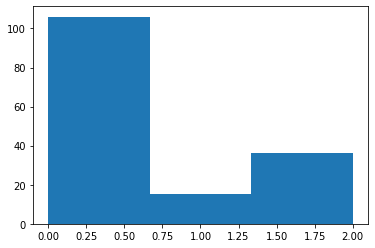

In [84]:
plt.hist(perf_model_small['course_id'],bins=3)

(array([ 1.,  0.,  1.,  0.,  2.,  1.,  0.,  3.,  4.,  2.,  4.,  6.,  6.,
        10., 10.,  6.,  2.,  1.,  2.,  1.,  2.,  1.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([-0.31216142, -0.29083567, -0.26950992, -0.24818418, -0.22685843,
        -0.20553269, -0.18420694, -0.16288119, -0.14155545, -0.1202297 ,
        -0.09890396, -0.07757821, -0.05625247, -0.03492672, -0.01360097,
         0.00772477,  0.02905052,  0.05037626,  0.07170201,  0.09302776,
         0.1143535 ,  0.13567925,  0.15700499,  0.17833074,  0.19965649,
         0.22098223,  0.24230798,  0.26363372,  0.28495947,  0.30628521,
         0.32761096]),
 <a list of 30 Patch objects>)

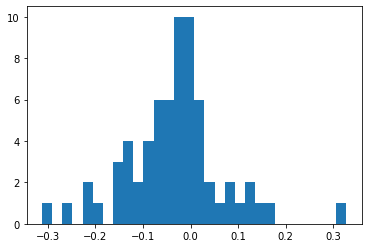

In [132]:
plt.hist(perf_model_small[perf_model_small['T_coeff'] !=0]['T_coeff'], bins = 30)

(array([21., 46., 47., 24., 10.,  3.,  3.,  0.,  2.,  1.]),
 array([ 1.38721535,  5.74849382, 10.10977228, 14.47105075, 18.83232921,
        23.19360768, 27.55488614, 31.91616461, 36.27744307, 40.63872154,
        45.        ]),
 <a list of 10 Patch objects>)

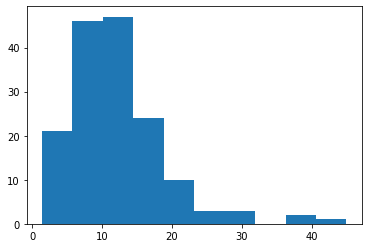

In [86]:
plt.hist(perf_model_small['mse'])

(array([1., 0., 0., 0., 1., 0., 1., 1., 1., 2., 3., 0., 4., 4., 2., 8., 3.,
        3., 2., 5., 5., 2., 0., 0., 2., 0., 1., 0., 0., 2.]),
 array([-84.89305583, -77.9030638 , -70.91307177, -63.92307974,
        -56.93308771, -49.94309568, -42.95310365, -35.96311162,
        -28.97311959, -21.98312757, -14.99313554,  -8.00314351,
         -1.01315148,   5.97684055,  12.96683258,  19.95682461,
         26.94681664,  33.93680867,  40.9268007 ,  47.91679273,
         54.90678476,  61.89677679,  68.88676882,  75.87676085,
         82.86675288,  89.85674491,  96.84673694, 103.83672897,
        110.826721  , 117.81671303, 124.80670506]),
 <a list of 30 Patch objects>)

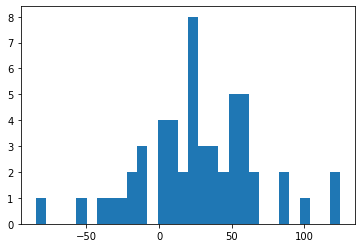

In [131]:
plt.hist(perf_model_small[perf_model_small['precip_coeff'] != 0]['precip_coeff'], bins = 30)

(array([ 2.,  0.,  0.,  0.,  1.,  2.,  0.,  3.,  2.,  1.,  4.,  7.,  6.,
        12., 11.,  3.,  4.,  2.,  3.,  3.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([-0.61169779, -0.5573407 , -0.5029836 , -0.44862651, -0.39426942,
        -0.33991233, -0.28555523, -0.23119814, -0.17684105, -0.12248395,
        -0.06812686, -0.01376977,  0.04058732,  0.09494442,  0.14930151,
         0.2036586 ,  0.2580157 ,  0.31237279,  0.36672988,  0.42108697,
         0.47544407,  0.52980116,  0.58415825,  0.63851535,  0.69287244,
         0.74722953,  0.80158662,  0.85594372,  0.91030081,  0.9646579 ,
         1.01901499]),
 <a list of 30 Patch objects>)

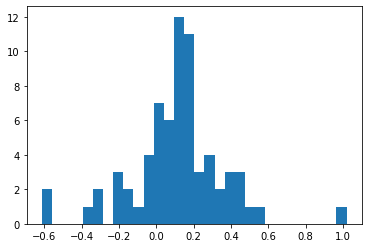

In [130]:
plt.hist(perf_model_small[perf_model_small['wspd_coeff'] != 0]['wspd_coeff'], bins = 30)

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 4., 8., 3.,
        8., 9., 8., 7., 5., 5., 2., 2., 1., 1., 0., 0., 1.]),
 array([-0.47689332, -0.44850002, -0.42010673, -0.39171343, -0.36332014,
        -0.33492684, -0.30653355, -0.27814025, -0.24974696, -0.22135366,
        -0.19296037, -0.16456707, -0.13617377, -0.10778048, -0.07938718,
        -0.05099389, -0.02260059,  0.0057927 ,  0.034186  ,  0.06257929,
         0.09097259,  0.11936588,  0.14775918,  0.17615247,  0.20454577,
         0.23293906,  0.26133236,  0.28972566,  0.31811895,  0.34651225,
         0.37490554]),
 <a list of 30 Patch objects>)

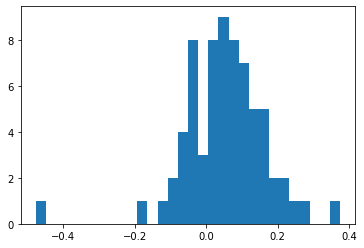

In [129]:
plt.hist(perf_model_small[perf_model_small['wgust_coeff'] != 0]['wgust_coeff'], bins = 30)

(array([ 1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  2.,  2.,  4.,  5.,  4.,
         2.,  6., 10.,  6.,  5.,  4.,  5.,  1.,  0.,  1.,  1.,  0.,  1.,
         0.,  1.,  3.,  1.]),
 array([-1.78135911e-03, -1.66696597e-03, -1.55257283e-03, -1.43817970e-03,
        -1.32378656e-03, -1.20939342e-03, -1.09500028e-03, -9.80607145e-04,
        -8.66214007e-04, -7.51820870e-04, -6.37427732e-04, -5.23034594e-04,
        -4.08641457e-04, -2.94248319e-04, -1.79855181e-04, -6.54620439e-05,
         4.89310937e-05,  1.63324231e-04,  2.77717369e-04,  3.92110507e-04,
         5.06503644e-04,  6.20896782e-04,  7.35289919e-04,  8.49683057e-04,
         9.64076195e-04,  1.07846933e-03,  1.19286247e-03,  1.30725561e-03,
         1.42164875e-03,  1.53604188e-03,  1.65043502e-03]),
 <a list of 30 Patch objects>)

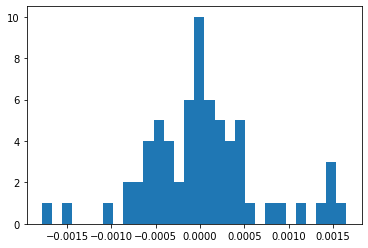

In [133]:
plt.hist(perf_model_small[perf_model_small['dirvar_coeff'] !=0]['dirvar_coeff'], bins = 30)

(array([78., 16., 22., 18., 10.,  3.,  3.,  2.,  4.,  1.]),
 array([0.        , 0.07879916, 0.15759832, 0.23639748, 0.31519665,
        0.39399581, 0.47279497, 0.55159413, 0.63039329, 0.70919245,
        0.78799162]),
 <a list of 10 Patch objects>)

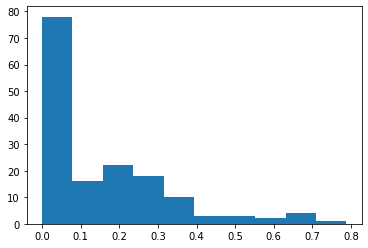

In [90]:
plt.hist(perf_model_small['prediction_score'])

In [91]:
coeff_count = []
for row in perf_model_small.iterrows():
    tmp_count = 0
    if row[1]['cumgame_coeff'] and (abs(row[1]['cumgame_coeff']) > 0.000001):
        tmp_count += 1
    if row[1]['T_coeff'] and (abs(row[1]['T_coeff']) > 0.000001):
        tmp_count += 1
    if row[1]['precip_coeff'] and (abs(row[1]['precip_coeff']) > 0.000001):
        tmp_count += 1
    if row[1]['wgust_coeff'] and (abs(row[1]['wgust_coeff']) > 0.000001):
        tmp_count += 1
    if row[1]['wspd_coeff'] and (abs(row[1]['wspd_coeff']) > 0.000001):
        tmp_count += 1
    if row[1]['dirvar_coeff'] and (abs(row[1]['dirvar_coeff']) > 0.000001):
        tmp_count += 1
    coeff_count.append(tmp_count)
perf_model_small['coeff_count'] = coeff_count
perf_model_small.head()

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


T_coeff      alpha  course_id  cumgame_coeff  dirvar_coeff  intercept  \
5  -0.059120   1.711020          2            NaN      0.000038  56.679093   
6  -0.049826   1.029388          0            NaN      0.000081  52.243656   
7  -0.147365   1.711020          1            NaN     -0.000623  66.224316   
8  -0.000000   0.825510          2            NaN     -0.000000  52.208302   
10 -0.000000  10.000000          1            NaN     -0.000000  65.000000   

      l1        mse  n_iter  n_values               player  precip_coeff  \
5   0.05  10.659072     6.0        23           Bob Montes     56.543837   
6   0.05   2.208735     7.0        11        Dennis Warsen      4.289653   
7   0.05   8.682143     5.0        14        Dennis Warsen           NaN   
8   0.50  13.921088    12.0        53        Dennis Warsen      0.000000   
10  0.20  12.500000     1.0         8  Gonzalo Arestizabal           NaN   

    prediction_score  removed_corr  wgust_coeff  wspd_coeff  coeff_count  
5           0.236162           0.0     0.137270    0.195796            5  
6           0.325109           0.0     0.081629    0.132396            5  
7           0.461487           1.0     0.119753    0.168692            4  
8           0.126004           0.0     0.167198    0.092093            2  
10          0.000000           1.0    -0.000000    0.000000            0

In [92]:
perf_model_small.coeff_count.value_counts()

0    60
5    30
4    25
1    20
3    11
2    11
Name: coeff_count, dtype: int64

In [93]:
perf_model_small.alpha.min()

0.21387755102040817

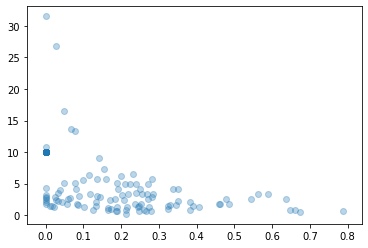

In [94]:
plt.scatter(x=perf_model_small.prediction_score,y=perf_model_small.alpha, alpha = 0.3)

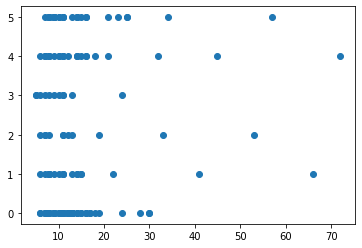

In [95]:
plt.scatter(x=perf_model_small.n_values, y=perf_model_small.coeff_count)

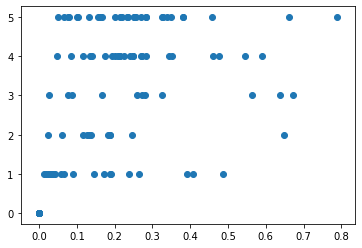

In [96]:
plt.scatter(x=perf_model_small.prediction_score, y=perf_model_small.coeff_count)

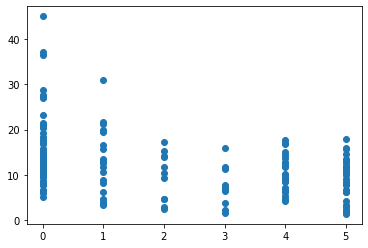

In [97]:
plt.scatter(x=perf_model_small.coeff_count, y=perf_model_small.mse)

In [117]:
list(perf_model_small.columns)

['T_coeff',
 'alpha',
 'course_id',
 'cumgame_coeff',
 'dirvar_coeff',
 'intercept',
 'l1',
 'mse',
 'n_iter',
 'n_values',
 'player',
 'precip_coeff',
 'prediction_score',
 'removed_corr',
 'wgust_coeff',
 'wspd_coeff',
 'coeff_count']

In [125]:
[(col, perf_model_small[perf_model_small[col] != 0][col].mean(), 
 perf_model_small[perf_model_small[col] != 0][col].std()) for col in list(perf_model_small.columns) if col != 'player']

[('T_coeff', -0.03414428961664803, 0.10120460538031932),
 ('alpha', 5.684919728941567, 4.75070680162162),
 ('course_id', 1.7058823529411764, 0.46017899330842227),
 ('cumgame_coeff', nan, nan),
 ('dirvar_coeff', 2.4551892687941338e-05, 0.0006469434346615954),
 ('intercept', 58.29021306601422, 6.083157784594636),
 ('l1', 0.33433121019108275, 0.3193247560916836),
 ('mse', 12.118328472760245, 6.889088681221772),
 ('n_iter', 3.738853503184713, 4.162017657916814),
 ('n_values', 13.961783439490446, 10.239995336486363),
 ('precip_coeff', 27.59904206443039, 40.813515618642036),
 ('prediction_score', 0.2332486115263072, 0.16736036031687768),
 ('removed_corr', 1.0769230769230769, 0.2699527623995085),
 ('wgust_coeff', 0.05157973024445388, 0.11820302142679943),
 ('wspd_coeff', 0.11192519575742012, 0.2513748179595838),
 ('coeff_count', 3.350515463917526, 1.527806414393703)]

In [99]:
perf_model_small.mean()

T_coeff             -0.014571
alpha                5.684920
course_id            0.554140
cumgame_coeff             NaN
dirvar_coeff         0.000011
intercept           58.290213
l1                   0.334331
mse                 12.118328
n_iter               3.738854
n_values            13.961783
precip_coeff        12.396180
prediction_score     0.144109
removed_corr         0.267516
wgust_coeff          0.022814
wspd_coeff           0.049190
coeff_count          2.070064
dtype: float64

In [100]:
perf_model_small.std()

T_coeff              0.067973
alpha                4.750707
course_id            0.842728
cumgame_coeff             NaN
dirvar_coeff         0.000424
intercept            6.083158
l1                   0.319325
mse                  6.889089
n_iter               4.162018
n_values            10.239995
precip_coeff        30.502433
prediction_score     0.173680
removed_corr         0.485457
wgust_coeff          0.082402
wspd_coeff           0.175071
coeff_count          2.025842
dtype: float64

In [101]:
perf_model_small[['player','course_id','mse','coeff_count']].sort_values(by='mse')

player  course_id        mse  coeff_count
969                 Jake Ward          0   1.387215            5
133              Matty Angell          1   1.685748            3
1023           Marquis Mallen          0   1.709850            5
23              Juan Fielding          2   2.185550            3
6               Dennis Warsen          0   2.208735            5
798               Dan Santini          0   2.437075            2
705                 Mike Sale          0   2.981308            2
873          Trevor Duckworth          0   2.984650            5
1074             Randy Waters          0   3.316928            5
1077              Ryan Santos          0   3.341589            1
126               Joe Kestler          0   3.667146            1
19               Jon Braidman          1   3.853628            3
963              Erica Norton          0   3.908192            1
260              Beau Griffin          2   4.208245            4
135               Mike Degnan          0   4.260489            5
444               Joe Dannels          0   4.611489            2
226               Matt Hansen          1   4.681820            1
927               Kevin Smeds          0   4.732644            2
720                Niel Jones          0   4.774943            4
843               Life Gibson          0   5.135802            0
813                 Eric Leaf          0   5.405955            4
74              David Falzone          2   5.950617            0
1056              Brett Allen          0   6.130084            5
660              Kevin Eckert          0   6.218965            1
11        Gonzalo Arestizabal          2   6.253195            4
182              Luiz Celeste          2   6.287787            5
567                   Ben Fox          0   6.330579            0
356             Soki Hagiwara          2   6.399261            3
783             Bryan Schmitz          0   6.420629            4
942              Mick Coronel          0   6.437500            0
...                       ...        ...        ...          ...
196         Arthur Coddington          1  16.910341            4
286             Marc Atkinson          1  16.916667            0
101              Bob McGarity          2  17.100210            4
648               Joe Donahue          0  17.240000            0
657              Josh Schmidt          0  17.248741            2
252   Daniel Charlip-Blumlein          0  17.265306            0
240               Shawn Mercy          0  17.500000            0
753                 Steven P.          0  17.621302            0
792             Chris Tirrell          0  17.677315            4
804           Dave Van Dollen          0  17.833645            5
314                  Zac Pape          2  18.456747            0
630       Eldridge Manchester          0  19.166667            0
915                Joe Canose          0  19.434555            1
831               Josh Babiak          0  19.636344            1
801           Daniel Johengen          0  19.995006            1
1035           Thor Scordelis          0  20.395062            0
561           Andy Rothschild          0  20.875346            0
588          Chris Vanleemput          0  21.107438            0
744              Sean Pierson          0  21.192810            1
747               Sean Saxton          0  21.360000            0
338             Roger Cansler          2  21.754256            1
609          Daniel Humphreys          0  23.283951            0
489                John Drago          0  26.859375            0
339               Andy Nguyen          0  27.428571            0
579           Candace Romaine          0  27.597633            0
129               Matt Neiman          0  28.710059            0
95                Aaron Kirby          2  30.953719            1
1068               Nick Klein          0  36.359375            0
1254        Sylvain Pelletier          0  37.102041            0
308               Nate Tilman          2  45.000000       

In [102]:
perf_model_small.sort_values(by='prediction_score',ascending=False).head()

T_coeff     alpha  course_id  cumgame_coeff  dirvar_coeff  intercept  \
969  -0.214726  0.621633          0            NaN      0.000250  69.899195   
19   -0.264028  0.427755          1            NaN     -0.000392  73.722457   
1074 -0.209207  0.855510          0            NaN     -0.001061  76.997068   
444  -0.312161  0.855510          0            NaN      0.000000  69.816125   
133   0.000303  2.560000          1            NaN           NaN  54.884803   

        l1       mse  n_iter  n_values        player  precip_coeff  \
969   0.05  1.387215     9.0         9     Jake Ward     24.376450   
19    0.99  3.853628    14.0        11  Jon Braidman           NaN   
1074  0.05  3.316928     8.0         9  Randy Waters      7.193448   
444   0.40  4.611489     4.0        12   Joe Dannels     45.608696   
133   0.05  1.685748     5.0         5  Matty Angell           NaN   

      prediction_score  removed_corr  wgust_coeff  wspd_coeff  coeff_count  
969           0.787992           0.0     0.105301    0.204910            5  
19            0.673009           1.0     0.057198   -0.000000            3  
1074          0.660769           0.0     0.016341    0.184927            5  
444           0.647342           0.0     0.000000    0.000000            2  
133           0.636692           2.0     0.161420    0.498873            3

In [103]:
perf_model_df.mean()

T_coeff             -0.014571
alpha                5.712230
course_id            1.000000
cumgame_coeff        0.002083
dirvar_coeff         0.000011
intercept           61.717697
l1                   0.334747
mse                 23.001302
n_iter               3.721519
n_values             2.109731
precip_coeff        12.396180
prediction_score     0.138183
removed_corr         0.321429
wgust_coeff          0.022669
wspd_coeff           0.048879
dtype: float64

In [104]:
perf_model_df.std()

T_coeff              0.067973
alpha                4.747980
course_id            0.816778
cumgame_coeff        1.006876
dirvar_coeff         0.000422
intercept            8.824437
l1                   0.318349
mse                 15.126925
n_iter               4.154460
n_values             5.458251
precip_coeff        30.502433
prediction_score     0.172571
removed_corr         0.530915
wgust_coeff          0.082158
wspd_coeff           0.174556
dtype: float64

In [105]:
perf_model_with_zeros = perf_model_df.fillna(0)
perf_model_with_zeros.head()

T_coeff  alpha  course_id  cumgame_coeff  dirvar_coeff  intercept   l1  \
0      0.0    0.0          0            0.0           0.0  68.111111  0.0   
1      0.0    0.0          1            0.0           0.0  68.111111  0.0   
2      0.0   10.0          2            0.0          -0.0  68.111111  0.4   
3      0.0    0.0          0            0.0           0.0  54.607143  0.0   
4      0.0    0.0          1            0.1           0.0  52.400000  0.0   

         mse  n_iter  n_values      player  precip_coeff  prediction_score  \
0  18.361111     0.0         0   Ben Horst           0.0          0.000000   
1  18.361111     0.0         0   Ben Horst           0.0          0.000000   
2  16.320988     1.0         9   Ben Horst           0.0          0.000000   
3  14.025132     0.0         0  Bob Montes           0.0          0.000000   
4   6.620000     0.0         5  Bob Montes           0.0          0.003012   

   removed_corr  wgust_coeff  wspd_coeff  
0           0.0          0.0         0.0  
1           0.0          0.0         0.0  
2           2.0          0.0         0.0  
3           0.0          0.0         0.0  
4           1.0          0.0         0.0

In [106]:
perf_model_df['mse'].value_counts().sort_index().head()

1.111222    59
1.260000     1
1.333333     2
1.333333     1
1.387215     1
Name: mse, dtype: int64

In [107]:
perf_model_with_zeros.to_csv('../score_model_data/score_model.csv')
perf_model_with_zeros.to_csv('../score_model_data/score_model_20190804b.csv')
len(perf_model_with_zeros)

1449

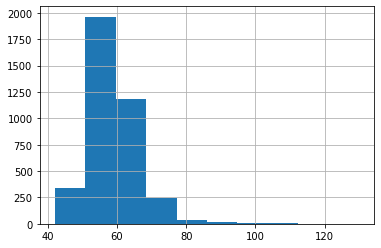

In [53]:
scores_df.Raw.hist()